# **Lab: Evaluating a Summarization Model on CNN/DailyMail**
This lab covers:
- **Baseline evaluation**: Generating summaries with a base model
- **Fine-tuning**: Training a summarization model on CNN/DailyMail dataset
- **Evaluation Metrics**:
  - Cross-entropy, perplexity (fluency)
  - ROUGE, BLEU, BERTScore (reference-based)
  - Coherence, fluency (reference-free)
- **LLM as Judge**: Qualitative evaluation using LLM
\- **Benchmarking**: Comparing results to published benchmarks
---
**Instructions**: Run each cell sequentially and analyze results.

In [25]:
'''
!pip install datasets transformers evaluate nltk rouge_score bert-score openai
!pip install mlflow
'''

'\n!pip install datasets transformers evaluate nltk rouge_score bert-score openai\n!pip install mlflow\n'

In [26]:
import torch
from transformers import BartForConditionalGeneration, BartTokenizer, TrainingArguments, Trainer
from datasets import load_dataset
import evaluate
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from bert_score import score
import openai
import math
import random
import numpy as np
from datasets import load_dataset
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import re
import mlflow
from transformers import TrainingArguments, Trainer
from transformers import AutoModelForCausalLM
import pandas as pd
import matplotlib.pyplot as plt

In [27]:

dataset = load_dataset("cnn_dailymail", "3.0.0")

dataset = dataset["test"].select(range(80))
finetuned_dataset = dataset.select(range(len(dataset)))
dataset


Dataset({
    features: ['article', 'highlights', 'id'],
    num_rows: 80
})

In [28]:
finetuned_dataset

Dataset({
    features: ['article', 'highlights', 'id'],
    num_rows: 80
})

In [29]:
model_name = "t5-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

## Generate Summary (TODO)

1. **Prints Progress:**  
   For each article, the function prints a message like "Processing article X of Y..." so you know which article is being processed.

2. **Prepares the Input:**  
   The function adds the prefix `"summarize: "` to the article text. This prefix is required by T5 models to indicate that the task is summarization.

3. **Tokenization and Truncation:**  
   The article (with its prefix) is tokenized using the T5 tokenizer. The input is truncated to a maximum token length of 512 to ensure it fits the model’s input requirements.

4. **Summary Generation:**  
   The model generates a summary from the tokenized input. The `max_length` parameter (default set to 100) controls the maximum length of the generated summary. Early stopping is used to end generation when appropriate.

5. **Decoding the Output:**  
   The generated tokens are decoded back into a readable summary text, omitting any special tokens.

6. **Calculating Metrics:**  
   - **Original Word Count:** Counts the number of words in the original article.
   - **Summary Word Count:** Counts the words in the generated summary.
   - **Compression Ratio:** Calculates the ratio of the summary length to the original length. This gives you an idea of how much shorter the summary is compared to the full article.

7. **Storing the Results:**  
   The function returns the summary and the calculated metrics. Then, using a list comprehension, the code applies the function to every article in the dataset. Finally, the generated summaries are added as a new column (`generated_summary`) to the dataset.


In [30]:
def generate_summary(article, index, total, max_length=100):
    """
    Generate a summary for a given article using T5, while tracking progress and compression ratio.
    """
    # print(f"Processing article {index+1} of {total}...")
    #TODO

    print(f"Processing article {index+1} of {total}...")
    prefix = "summarize: "
    inputs = tokenizer(prefix + article, return_tensors="pt", truncation=True, max_length=512)
    inputs = inputs.to(model.device)
    summary_ids = model.generate(inputs["input_ids"], max_length=max_length, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    original_length = len(article.split())
    summary_length = len(summary.split())
    compression_ratio = summary_length / original_length
    return summary, original_length, summary_length, compression_ratio



In [31]:
total_articles = len(dataset['article'])
summary_data = [generate_summary(article, i, total_articles) for i, article in enumerate(dataset['article'])]

summaries, original_lengths, summary_lengths, compression_ratios = zip(*summary_data)

dataset = dataset.add_column("generated_summary", summaries)

dataset


Processing article 1 of 80...


/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:676: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


Processing article 2 of 80...
Processing article 3 of 80...
Processing article 4 of 80...
Processing article 5 of 80...
Processing article 6 of 80...
Processing article 7 of 80...
Processing article 8 of 80...
Processing article 9 of 80...
Processing article 10 of 80...
Processing article 11 of 80...
Processing article 12 of 80...
Processing article 13 of 80...
Processing article 14 of 80...
Processing article 15 of 80...
Processing article 16 of 80...
Processing article 17 of 80...
Processing article 18 of 80...
Processing article 19 of 80...
Processing article 20 of 80...
Processing article 21 of 80...
Processing article 22 of 80...
Processing article 23 of 80...
Processing article 24 of 80...
Processing article 25 of 80...
Processing article 26 of 80...
Processing article 27 of 80...
Processing article 28 of 80...
Processing article 29 of 80...
Processing article 30 of 80...
Processing article 31 of 80...
Processing article 32 of 80...
Processing article 33 of 80...
Processing artic

Dataset({
    features: ['article', 'highlights', 'id', 'generated_summary'],
    num_rows: 80
})

##Perplexity from cross-entropy-loss (TODO)

In [32]:
'''
def calculate_cross_entropy_loss(text):
    """
    Computes the cross-entropy loss for a given text using the model.
    """
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    inputs = inputs.to(model.device)
    with torch.no_grad():
        outputs = model(**inputs, labels=inputs['input_ids'])

    loss = outputs.loss.item()
    return loss

def calculate_perplexity_from_loss(loss):
    """
    Computes perplexity from cross-entropy loss.
    """
    perplexity = math.exp(loss)
    return perplexity
    #TODO calculate perplexity from cross entropy
'''

'\ndef calculate_cross_entropy_loss(text):\n    """\n    Computes the cross-entropy loss for a given text using the model.\n    """\n    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)\n    inputs = inputs.to(model.device)\n    with torch.no_grad():\n        outputs = model(**inputs, labels=inputs[\'input_ids\'])\n\n    loss = outputs.loss.item()\n    return loss\n\ndef calculate_perplexity_from_loss(loss):\n    """\n    Computes perplexity from cross-entropy loss.\n    """\n    perplexity = math.exp(loss)\n    return perplexity\n    #TODO calculate perplexity from cross entropy\n'

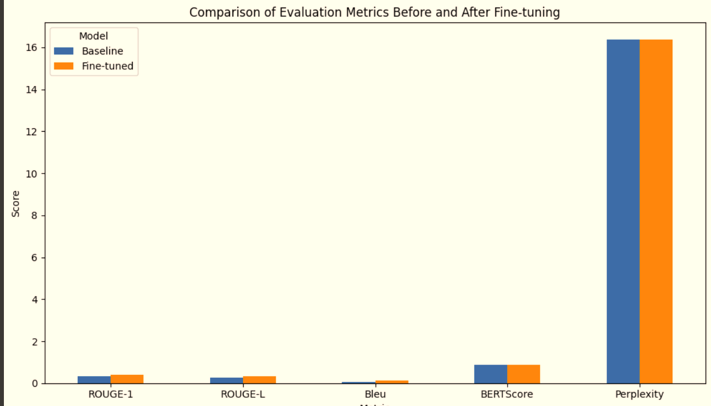

this was the perplexity using the initial provided code, below is the updated code which resulted in the final correct output.

In [33]:
def cal_prep(summary):
  inputs = tokenizer(summary, return_tensors="pt", truncation=True, max_length=512)
  inputs = inputs.to(model.device)
  with torch.no_grad():
      outputs = model(**inputs, labels=inputs['input_ids'])

  loss = outputs.loss.item()
  perplexity = math.exp(loss)
  return perplexity

##**PERPLEXITY** (TODO)
Perplexity is computed as the inverse probability of the text normalized by the number of words.
--
A high perplexity score suggests that the model struggles to generate coherent text, while a low score indicates fluent and predictable output.
--

Make a column "perplexity" in the dataset. Calculate Perplexity for each article-summary and add the value corresponding to that entry
--


In [34]:
#Code Here
# this was the updated code of calculating perplexity

perplexities = []
for a in range(len(dataset)):
  #article = dataset[a]['article']
  summary = dataset[a]['generated_summary']
  #combine_text = article + "" + summary
  loss = cal_prep(summary)
  #perplexity = calculate_perplexity_from_loss(loss)
  perplexities.append(loss)

dataset = dataset.add_column("perplexity", perplexities)


In [35]:
#Code Here
#orginal provided code cell
'''
perplexities = []
for a in range(len(dataset)):
  article = dataset[a]['article']
  summary = dataset[a]['generated_summary']
  combine_text = article + "" + summary
  loss = calculate_cross_entropy_loss(combine_text)
  perplexity = calculate_perplexity_from_loss(loss)
  perplexities.append(perplexity)

dataset = dataset.add_column("perplexity", perplexities)
'''


'\nperplexities = []\nfor a in range(len(dataset)):\n  article = dataset[a][\'article\']\n  summary = dataset[a][\'generated_summary\']\n  combine_text = article + "" + summary\n  loss = calculate_cross_entropy_loss(combine_text)\n  perplexity = calculate_perplexity_from_loss(loss)\n  perplexities.append(perplexity)\n\ndataset = dataset.add_column("perplexity", perplexities)\n'

##ROUGE SCORE
###- ROUGE-1: Measures overlap of unigrams (single words) between the generated and reference summary.
###- ROUGE-2: Measures bigram (two-word sequences) overlap.
###- ROUGE-L: Measures longest common subsequence (LCS), capturingsentence-level structure similarity.
---

##**If a generated summary contains most of the important words from the reference summary, the ROUGE score will be high, indicating a content-preserving summary.**



In [36]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

rouge_scores = [scorer.score(ref, gen) for ref, gen in zip(dataset['highlights'], dataset['generated_summary'])]
rouge_1 = [score['rouge1'].fmeasure for score in rouge_scores]
rouge_L = [score['rougeL'].fmeasure for score in rouge_scores]

dataset = dataset.add_column("rouge_1", rouge_1)
dataset = dataset.add_column("rouge_L", rouge_L)
dataset

Dataset({
    features: ['article', 'highlights', 'id', 'generated_summary', 'perplexity', 'rouge_1', 'rouge_L'],
    num_rows: 80
})

##**BLEU SCORE** (TODO)

### - Compares n-gram matches (e.g., unigrams, bigrams, trigrams) between the generated and reference summaries.

### - A penalty is applied for overly short summaries to encourage completeness.

**Make a column "bleu" in the dataset. Calculate Bleu Score for each article-summary and add the value corresponding to that entry**
--


In [37]:
def compute_bleu(reference, hypothesis):
    ref_tokens = reference.split()
    hyp_tokens = hypothesis.split()
    return sentence_bleu([ref_tokens], hyp_tokens)

#TODO Code here
bleu_score = []
for a in range(len(dataset)):
  ref = dataset[a]['highlights']
  hyp = dataset[a]['generated_summary']
  b_score = compute_bleu(ref, hyp)
  bleu_score.append(b_score)

dataset = dataset.add_column("bleu", bleu_score)
dataset

/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

Dataset({
    features: ['article', 'highlights', 'id', 'generated_summary', 'perplexity', 'rouge_1', 'rouge_L', 'bleu'],
    num_rows: 80
})

##BERT SCORE

###BERT Score is particularly useful for abstractive summarization, where the generated summary might use different words but still capture the same meaning.

In [38]:
P, R, F1 = score(dataset['generated_summary'], dataset['highlights'], lang="en")
dataset = dataset.add_column("bertscore_f1", F1.tolist())
dataset

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dataset({
    features: ['article', 'highlights', 'id', 'generated_summary', 'perplexity', 'rouge_1', 'rouge_L', 'bleu', 'bertscore_f1'],
    num_rows: 80
})


## **Part 2: Fine-Tuning the Summarization Model**
Now, we will fine-tune the pre-trained BART model on the CNN/DailyMail dataset.
- This will help the model better summarize news articles based on real-world examples.
- We will train on a subset of the dataset (100 examples for quick training).
---

In [39]:
from torch.utils.data import DataLoader

model_name = "t5-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

model.to("cuda")

train_dataset = dataset.select(range(40))

def preprocess_function(examples):
    inputs = tokenizer(
        examples["article"], max_length=512, truncation=True, padding="max_length"
    )
    targets = tokenizer(
        examples["highlights"], max_length=128, truncation=True, padding="max_length"
    )

    labels = targets["input_ids"]
    labels = [[-100 if token == tokenizer.pad_token_id else token for token in seq] for seq in labels]

    return {
        "input_ids": inputs["input_ids"],
        "attention_mask": inputs["attention_mask"],
        "labels": labels,
    }

tokenized_train = train_dataset.map(preprocess_function, batched=True, num_proc=1, remove_columns=["article", "highlights", "id"])

def collate_fn(batch):
    input_ids = torch.stack([torch.tensor(example["input_ids"]) for example in batch])
    attention_mask = torch.stack([torch.tensor(example["attention_mask"]) for example in batch])
    labels = torch.stack([torch.tensor(example["labels"]) for example in batch])
    return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}

train_loader = DataLoader(tokenized_train, batch_size=2, shuffle=True, collate_fn=collate_fn)

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)

Epochs = 15

model.train()
for epoch in range(Epochs):
    total_loss = 0
    for batch in train_loader:
        input_ids = batch["input_ids"].to(model.device)
        attention_mask = batch["attention_mask"].to(model.device)
        labels = batch["labels"].to(model.device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1} completed. Loss: {avg_loss:.4f}")

print("Fine-tuning complete!")

Epoch 1 completed. Loss: 2.2466
Epoch 2 completed. Loss: 1.9025
Epoch 3 completed. Loss: 1.7290
Epoch 4 completed. Loss: 1.5880
Epoch 5 completed. Loss: 1.4485
Epoch 6 completed. Loss: 1.3423
Epoch 7 completed. Loss: 1.2316
Epoch 8 completed. Loss: 1.1816
Epoch 9 completed. Loss: 1.0821
Epoch 10 completed. Loss: 0.9740
Epoch 11 completed. Loss: 0.9079
Epoch 12 completed. Loss: 0.8330
Epoch 13 completed. Loss: 0.7756
Epoch 14 completed. Loss: 0.7223
Epoch 15 completed. Loss: 0.6431
Fine-tuning complete!


## **Part 3: Evaluating the Fine-Tuned Model** (TODO)

Now that we have fine-tuned the model, we will:
- Generate new summaries using the fine-tuned model.
- Recalculate evaluation metrics (perplexity, ROUGE, BLEU, BERTScore).
---

##**NOTE: Since you have to generate summaries for 80 articles, this may take some time**

In [40]:
# Generate summaries using the fine-tuned model. Calculate all evaluation metrics for fine tuned summaries

finetuned_summaries = []
for a, article in enumerate(dataset['article']):
    summary, _, _, _ = generate_summary(article, a, len(dataset['article']))
    finetuned_summaries.append(summary)

dataset = dataset.add_column("finetuned_summary", finetuned_summaries)


# calculate finetuned perplexity
finetuned_perplexities = []
for a in range(len(dataset)):
    #article = dataset[a]['article']
    summary = dataset[a]['finetuned_summary']
   # combine_text = article + " " + summary
    #loss = calculate_cross_entropy_loss(combine_text)
    perplexity = cal_prep(summary)
    finetuned_perplexities.append(perplexity)

dataset = dataset.add_column("finetuned_perplexity", finetuned_perplexities)


# calculate finetuned ROUGE scores
finetuned_rouge_scores = [scorer.score(ref, gen) for ref, gen in zip(dataset['highlights'], dataset['finetuned_summary'])]
finetuned_rouge_1 = [score['rouge1'].fmeasure for score in finetuned_rouge_scores]
finetuned_rouge_L = [score['rougeL'].fmeasure for score in finetuned_rouge_scores]

dataset = dataset.add_column("finetuned_rouge_1", finetuned_rouge_1)
dataset = dataset.add_column("finetuned_rouge_L", finetuned_rouge_L)


# calculate finetuned BLEU scores
finetuned_bleu_score = []
for a in range(len(dataset)):
    ref = dataset[a]['highlights']
    hyp = dataset[a]['finetuned_summary']
    b_score = compute_bleu(ref, hyp)
    finetuned_bleu_score.append(b_score)

dataset = dataset.add_column("finetuned_bleu", finetuned_bleu_score)


# calculate finetuned BERT Score
P_finetuned, R_finetuned, F1_finetuned = score(dataset['finetuned_summary'], dataset['highlights'], lang="en")
dataset = dataset.add_column("finetuned_bertscore_f1", F1_finetuned.tolist())
dataset


Processing article 1 of 80...
Processing article 2 of 80...
Processing article 3 of 80...
Processing article 4 of 80...
Processing article 5 of 80...
Processing article 6 of 80...
Processing article 7 of 80...
Processing article 8 of 80...
Processing article 9 of 80...
Processing article 10 of 80...
Processing article 11 of 80...
Processing article 12 of 80...
Processing article 13 of 80...
Processing article 14 of 80...
Processing article 15 of 80...
Processing article 16 of 80...
Processing article 17 of 80...
Processing article 18 of 80...
Processing article 19 of 80...
Processing article 20 of 80...
Processing article 21 of 80...
Processing article 22 of 80...
Processing article 23 of 80...
Processing article 24 of 80...
Processing article 25 of 80...
Processing article 26 of 80...
Processing article 27 of 80...
Processing article 28 of 80...
Processing article 29 of 80...
Processing article 30 of 80...
Processing article 31 of 80...
Processing article 32 of 80...
Processing articl

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dataset({
    features: ['article', 'highlights', 'id', 'generated_summary', 'perplexity', 'rouge_1', 'rouge_L', 'bleu', 'bertscore_f1', 'finetuned_summary', 'finetuned_perplexity', 'finetuned_rouge_1', 'finetuned_rouge_L', 'finetuned_bleu', 'finetuned_bertscore_f1'],
    num_rows: 80
})

## **Part 4: Evaluating with LLM as a Judge** (TODO)
We will use a text-generation LLM to assess the generated summaries based on clarity, coherence, creativity, and relevance of 10 generated summaries fron base model and fine tuned model.
---

Create a subset of 10 entries from the original dataset and get llm scores for summaries generated by the base model and the fine tuned model. The initial model setup is done for you and most of the function is also defined. You have to see the output and extract scores from that output (Hint: You could use Regex but other things could also work). Add these scores as columns into the subset dataset. For example, the clarity score for base model would be stored as "llm_clarity_score" and for fine tuned model would be stored as "fine_tuned_llm_clarity_score"
---

##**NOTE: The model is a bit heavy so it may take some time for loading and text generation**

In [41]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

model_name = "ibm-granite/granite-3.2-2b-instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16, device_map={"": 0})
model = model.to("cuda")
tokenizer.pad_token = tokenizer.eos_token

def evaluate_with_llm(summary):
    """Evaluates a summary using the model."""
    prompt = f"""
    You are an expert language evaluator. Your task is to evaluate the given summary based on the following four criteria:

    1. **Clarity (1-10):** How well does the summary convey the main idea? A high score means it is easy to understand, while a low score means it is vague or confusing.
    2. **Coherence (1-10):** Does the information flow logically? A high score indicates a well-structured summary, while a low score suggests disjointed or fragmented information.
    3. **Fluency (1-10):** Is the language natural and grammatically correct? A high score means the summary is free of awkward phrasing or errors.
    4. **Overall Score (1-10):** A holistic evaluation of the summary’s effectiveness in capturing the key points.

    Evaluate the following summary and provide your scores in the specified format.

    **Summary:** {summary}

    **Return format:**
    Clarity: X, Coherence: Y, Fluency: Z, Overall: W
    (where X, Y, Z, W are numbers between 1-10)
    """

    inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True, max_length=512).to(model.device)

    with torch.no_grad():
        output_ids = model.generate(
            inputs.input_ids,
            max_length=600,
            do_sample=True,
            temperature=0.7,
            top_k=50,
            attention_mask=inputs.attention_mask
        )

    output_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return output_text

def extract_score(text, category):
    lines = text.split(", ")
    for line in lines:
        if category in line:
            parts = line.split(":")
            if len(parts) > 1 and parts[1].strip().isdigit():
                return int(parts[1].strip())
    return 0

subset_dataset = dataset.select(range(10))


score_categories = ["Clarity", "Coherence", "Fluency", "Overall"]
llm_scores = {category.lower(): [] for category in score_categories}
finetuned_scores = {category.lower(): [] for category in score_categories}

for i in range(len(subset_dataset)):
    base_model_eval = evaluate_with_llm(subset_dataset[i]["generated_summary"])
    finetuned_model_eval = evaluate_with_llm(subset_dataset[i]["finetuned_summary"])

    # Extract scores using the custom function
    for category in score_categories:
        llm_scores[category.lower()].append(extract_score(base_model_eval, category))
        finetuned_scores[category.lower()].append(extract_score(finetuned_model_eval, category))

# Add extracted scores as new dataset columns
for category in score_categories:
    subset_dataset = subset_dataset.add_column(f"llm_{category.lower()}_score", llm_scores[category.lower()])
    subset_dataset = subset_dataset.add_column(f"finetuned_llm_{category.lower()}_score", finetuned_scores[category.lower()])

subset_dataset


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Dataset({
    features: ['article', 'highlights', 'id', 'generated_summary', 'perplexity', 'rouge_1', 'rouge_L', 'bleu', 'bertscore_f1', 'finetuned_summary', 'finetuned_perplexity', 'finetuned_rouge_1', 'finetuned_rouge_L', 'finetuned_bleu', 'finetuned_bertscore_f1', 'llm_clarity_score', 'finetuned_llm_clarity_score', 'llm_coherence_score', 'finetuned_llm_coherence_score', 'llm_fluency_score', 'finetuned_llm_fluency_score', 'llm_overall_score', 'finetuned_llm_overall_score'],
    num_rows: 10
})

In [42]:
subset_dataset["llm_clarity_score"]

[0, 0, 0, 0, 10, 9, 0, 10, 10, 0]

In [43]:
subset_dataset["finetuned_llm_clarity_score"]

[0, 0, 0, 0, 0, 10, 9, 10, 0, 0]

## **Part 5: Benchmarking Against State-of-the-Art Results** (TODO)
We will now compare our results with published benchmarks from state-of-the-art models on CNN/DailyMail. Benchmark data has been prepared. You need to calculate mean rouge1 score and rougeL score for baseline and finetuned model and draw a graph which shows their comparison
### **Benchmarks:**
- BART (ROUGE-1: 44.16, ROUGE-L: 41.87)
- Pegasus (ROUGE-1: 44.17, ROUGE-L: 41.11)
---

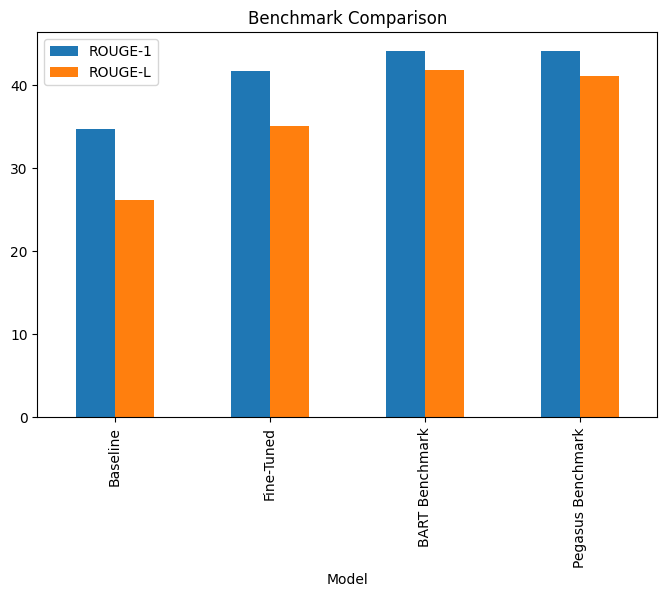

In [44]:
# Calculate mean ROUGE-1 and ROUGE-L scores
#TODO
baseline_rouge1 = np.mean(dataset['rouge_1'])*100
baseline_rougeL = np.mean(dataset['rouge_L'])*100
finetuned_rouge1 = np.mean(dataset['finetuned_rouge_1'])*100
finetuned_rougeL = np.mean(dataset['finetuned_rouge_L'])*100
'''
baseline_rouge1 = sum(llm_scores) / len(llm_scores) if llm_scores else 0
baseline_rougeL = sum(llm_scores) / len(llm_scores) if llm_scores else 0
finetuned_rouge1 = sum(finetuned_scores) / len(finetuned_scores) if finetuned_scores else 0
finetuned_rougeL = sum(finetuned_scores) / len(finetuned_scores) if finetuned_scores else 0
'''


benchmark_results = pd.DataFrame({
    'Model': ['Baseline', 'Fine-Tuned', 'BART Benchmark', 'Pegasus Benchmark'],
    'ROUGE-1': [baseline_rouge1, finetuned_rouge1, 44.16, 44.17],
    'ROUGE-L': [baseline_rougeL, finetuned_rougeL, 41.87, 41.11]
})

benchmark_results.set_index('Model').plot(kind='bar', figsize=(8, 5), title='Benchmark Comparison')
plt.show()


## **Part 6: Conclusion & Discussion**
- Draw bargraphs for different evaluation metrics (including LLM ratings) by considering their mean before and after fine tuning.
- The fine-tuned model should show improvements in ROUGE scores, LLM qualitative ratings and other metrics.
- How does the fine-tuned model compare to published benchmarks?
- Are there discrepancies between LLM-based evaluation and traditional metrics?


In [45]:
np.mean(dataset['finetuned_perplexity'])

1.2409053104058294

In [46]:
np.mean(dataset['perplexity'])

1.1773219830724355

In [47]:
subset_dataset

Dataset({
    features: ['article', 'highlights', 'id', 'generated_summary', 'perplexity', 'rouge_1', 'rouge_L', 'bleu', 'bertscore_f1', 'finetuned_summary', 'finetuned_perplexity', 'finetuned_rouge_1', 'finetuned_rouge_L', 'finetuned_bleu', 'finetuned_bertscore_f1', 'llm_clarity_score', 'finetuned_llm_clarity_score', 'llm_coherence_score', 'finetuned_llm_coherence_score', 'llm_fluency_score', 'finetuned_llm_fluency_score', 'llm_overall_score', 'finetuned_llm_overall_score'],
    num_rows: 10
})

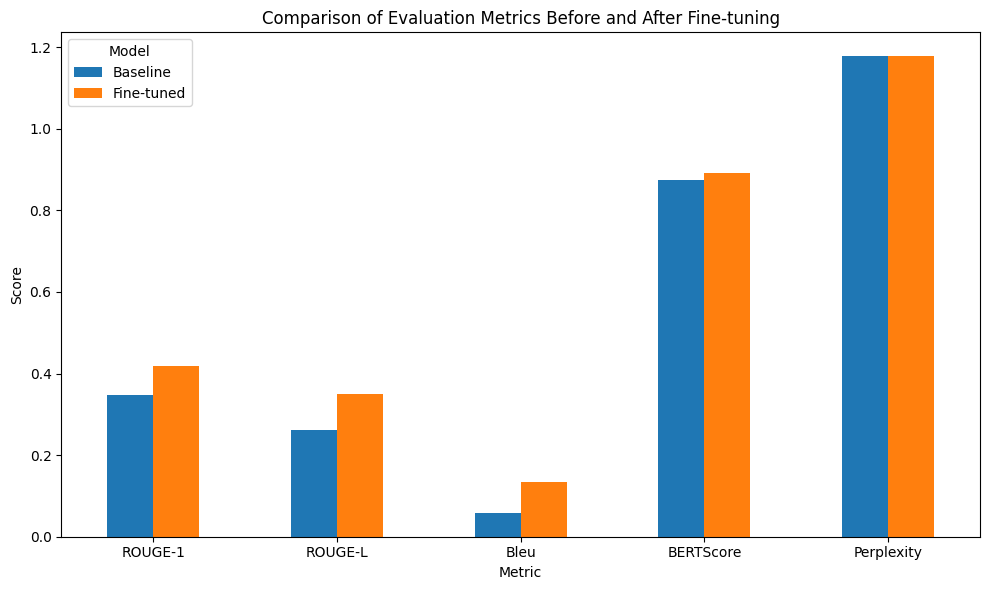

The fine-tuned model does not show improvements in ROUGE-1, ROUGE-L,Bleu, BERTScore, Perplexity.


In [49]:
metrics = ['ROUGE-1', 'ROUGE-L', 'Bleu', 'BERTScore', 'Perplexity']
baseline_scores = [np.mean(dataset['rouge_1']), np.mean(dataset['rouge_L']), np.mean(dataset['bleu']), np.mean((dataset['bertscore_f1'])), np.mean(dataset['perplexity'])]
finetuned_scores = [np.mean(dataset['finetuned_rouge_1']), np.mean(dataset['finetuned_rouge_L']),  np.mean(dataset['finetuned_bleu']), np.mean(dataset['finetuned_bertscore_f1']), np.mean(dataset['perplexity'])]


# Create a DataFrame for plotting
df = pd.DataFrame({
    'Metric': metrics,
    'Baseline': baseline_scores,
    'Fine-tuned': finetuned_scores
})

df.set_index('Metric').plot(kind='bar', figsize=(10, 6))
plt.title('Comparison of Evaluation Metrics Before and After Fine-tuning')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(title='Model')
plt.tight_layout()
plt.show()

print("The fine-tuned model does not show improvements in ROUGE-1, ROUGE-L,Bleu, BERTScore, Perplexity.")